# Imports


In [1]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

from bertopic import BERTopic
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#from torchmetrics import F1Score, Accuracy
from transformers import BertTokenizer, BertForSequenceClassification, get_cosine_schedule_with_warmup, AdamW
from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.model_selection import train_test_split
import plotly.figure_factory as ff
from matplotlib import pyplot as plt
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    multilabel_confusion_matrix,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_score,
    recall_score,
)

import re

import nltk
from nltk.corpus import stopwords
import string
import re
import matplotlib.pyplot as plt

# Data


In [12]:
df = pd.read_csv("for_clust.csv")
df

,Комментарий,Категория,corrected_tag,labels,temp
0,Видео лагает,Видео,VP,[0. 0. 0. 0. 0. 0. 1.],VP
1,Торгом Бабаян! Спасибо вам большое за помощь в...,ДЗ,H,[0. 1. 0. 0. 0. 0. 0.],H
2,Спасибо),ДЗ,H,[0. 1. 0. 0. 0. 0. 0.],H
3,комментарий содержит нерелевантную информацию ...,ДЗ,H E,[1. 1. 0. 0. 0. 0. 0.],H
4,комментарий содержит нерелевантную информацию ...,ДЗ,H E,[1. 1. 0. 0. 0. 0. 0.],E
...,...,...,...,...,...
68752,Крайне раздражают некоторые детали)\nНапример ...,NaN,LMS,[0. 0. 1. 0. 0. 0. 0.],LMS
68753,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN,VC VP,[0. 0. 0. 0. 0. 1. 1.],VC
68754,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN,VC VP,[0. 0. 0. 0. 0. 1. 1.],VP
68755,"Системный аналитик с нуля, 1-14 модули. Не нар...",NaN,VP VC,[0. 0. 0. 0. 0. 1. 1.],VP


# Data processing


In [13]:
nltk.download("stopwords")
def remove_rus_stopwords_func(text):
    '''
    Removes Stop Words (also capitalized) from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without Stop Words
    ''' 
    

   
    # check in lowercase 
    t = [token for token in text.split() if not token in set(stopwords.words("russian"))]
    text = ' '.join(t)    
    return text

def remove_emoji(inputString):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u2069"
    u"\u2066"
    u"\u200c"
    u"\u2068"
    u"\u2067"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', inputString)

def process_data(df):
    # df = df[(df['Категория'] != "Качество материалов") & (df['Категория'] != "Интерфейс платформы") & (df['Категория'] != "Общение с куратором")]
    
    # df = df[['Категория', 'Комментарий']].dropna()

    # df['Комментарий'] = df['Комментарий'].apply(lambda text: remove_rus_stopwords_func(text))

    df['Комментарий'] = df['Комментарий'].apply(lambda text: remove_emoji(text))

    # df = df[df.Комментарий.apply(lambda x: len(x.split())) > 1]

    # df.drop_duplicates(inplace=True, subset=['Комментарий'])
    
    rename = {
        'Категория': 'category',
        'Комментарий': 'text'
    }
    df = df.rename(columns=rename)
    return df

df = process_data(df)
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vsevo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,category,corrected_tag,labels,temp
0,Видео лагает,Видео,VP,[0. 0. 0. 0. 0. 0. 1.],VP
1,Торгом Бабаян! Спасибо вам большое за помощь в...,ДЗ,H,[0. 1. 0. 0. 0. 0. 0.],H
2,Спасибо),ДЗ,H,[0. 1. 0. 0. 0. 0. 0.],H
3,комментарий содержит нерелевантную информацию ...,ДЗ,H E,[1. 1. 0. 0. 0. 0. 0.],H
4,комментарий содержит нерелевантную информацию ...,ДЗ,H E,[1. 1. 0. 0. 0. 0. 0.],E
...,...,...,...,...,...
68752,Крайне раздражают некоторые детали)\nНапример ...,NaN,LMS,[0. 0. 1. 0. 0. 0. 0.],LMS
68753,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN,VC VP,[0. 0. 0. 0. 0. 1. 1.],VC
68754,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN,VC VP,[0. 0. 0. 0. 0. 1. 1.],VP
68755,"Системный аналитик с нуля, 1-14 модули. Не нар...",NaN,VP VC,[0. 0. 0. 0. 0. 1. 1.],VP


# Data exploration


In [14]:
df.category.value_counts()

category
Видео                  26251
ДЗ                     24564
Лонгрид                 2272
Тест                    1350
Качество материалов       44
Общение с куратором       11
Интерфейс платформы        6
Name: count, dtype: int64

Рассмотрим детальнее класс 'Общение с куратором'


In [15]:
df[df['category'] == 'Общение с куратором']['text'].to_list()

['Думаю, было бы очень хорошо, чтобы куратор связывался с учениками раз в неделю',
 'Перед покупкой курса со мной связывался куратор и обещал следить за продвижением моего курса. Этого не было',
 'Я прошел 1 lvl полностью. Почти завершил проект. \n Могу сказать о том, что за протяжении всего времени я испытывал кучу трудностей, которые пришлось решать разными методами и способами. \n Во-первых, стоит поговорить о подаче материала в видеоуроках. Курс явно не предназначен для человека, который вообще не разбирается в программировании. Вечно что-то глотающий-жующий лектор на видео, который использует заумные слова которые новичку будут абсолютно непонятны. Хотя бы можно было бы какой-то терминологический словарик дать, чтобы просто человек мог посмотреть в словарик и понять, что значит тот же "фреймворк". Если смотреть на roadmap курса и задачки которые даются - они очень даже хороши. С домашней работой и просто подбором поэтапной информации справились хорошо. Только вот в некоторых модул

В классе 'Общение с куратором' подозрительно мало элементов

Давайте попробуем найти примеры текстов, отноящиеся к этому классу, но размеченные иначе

Отберем те, в которых вречаетя слово 'куратор'


In [16]:
df[df.text.str.contains('(?i)куратор', 'i')]['text'].to_list()

['Валерия- отличный куратор! Буду дорабатывать дальше, чтобы представить достойно. Огромное спасибо!',
 'Кураторы работают и помогают в вопросах. Обучение без дедлайнов. Можно работать в удобном ритме.\nНе понятно объясняют. Человеку, который ни разу в жизни не работал в программах Adobe - будет очень трудно. Иногда в интернете приходится искать как исправить ту или иную проблему.',
 'Кураторы работают и помогают в вопросах. Обучение без дедлайнов. Можно работать в удобном ритме.\nНе понятно объясняют. Человеку, который ни разу в жизни не работал в программах Adobe - будет очень трудно. Иногда в интернете приходится искать как исправить ту или иную проблему.',
 'Кураторы работают и помогают в вопросах. Обучение без дедлайнов. Можно работать в удобном ритме.\nНе понятно объясняют. Человеку, который ни разу в жизни не работал в программах Adobe - будет очень трудно. Иногда в интернете приходится искать как исправить ту или иную проблему.',
 'Очень отзывчивый куратор  ',
 'Данный курс был

Эти примеры дейсвительно отноятся к нашему классу, но имеют следующие метки


In [17]:
df[df.text.str.contains('(?i)куратор', 'i')]['category'].value_counts()

category
ДЗ                     3975
Видео                   296
Лонгрид                  28
Общение с куратором      11
Качество материалов      10
Тест                      8
Name: count, dtype: int64

Исправим разметку


In [18]:
df.loc[df.text.str.contains('(?i)куратор', 'i'), ['category']] = 'Общение с куратором'

# Переразметка  помощью кластеризации 

Идея: Давайте кластеризуем тексты по семантичекой близости, а потом рассмотрим на распределение классов внутри кластера. Ели у нас есть внутри кластера есть доминирующий класс, то меняем разметку внутри кластера. 

# Кластеризация

Сначала давайте разберемя с кластризацией, будет ипользовать dbscan


In [20]:
docs = df['text'].values.tolist()

In [13]:


clust_cnt, elem_cnt = [], []
for eps in range(1, 11):
    eps = eps / 50
    cluster_model = DBSCAN(eps=eps, min_samples=5)
    topic_model = BERTopic(
        language="multilingual",
        embedding_model='cointegrated/rubert-tiny2',
        hdbscan_model=cluster_model)
    topics, probs = topic_model.fit_transform(docs)
    clust_res = topic_model.get_topic_info()
    clust_cnt.append(len(clust_res[clust_res.Topic != -1]))
    elem_cnt.append(clust_res[clust_res.Topic != -1].Count.sum())

eps_lst = [eps / 50 for eps in list(range(1, 11)) ]

KeyboardInterrupt: 

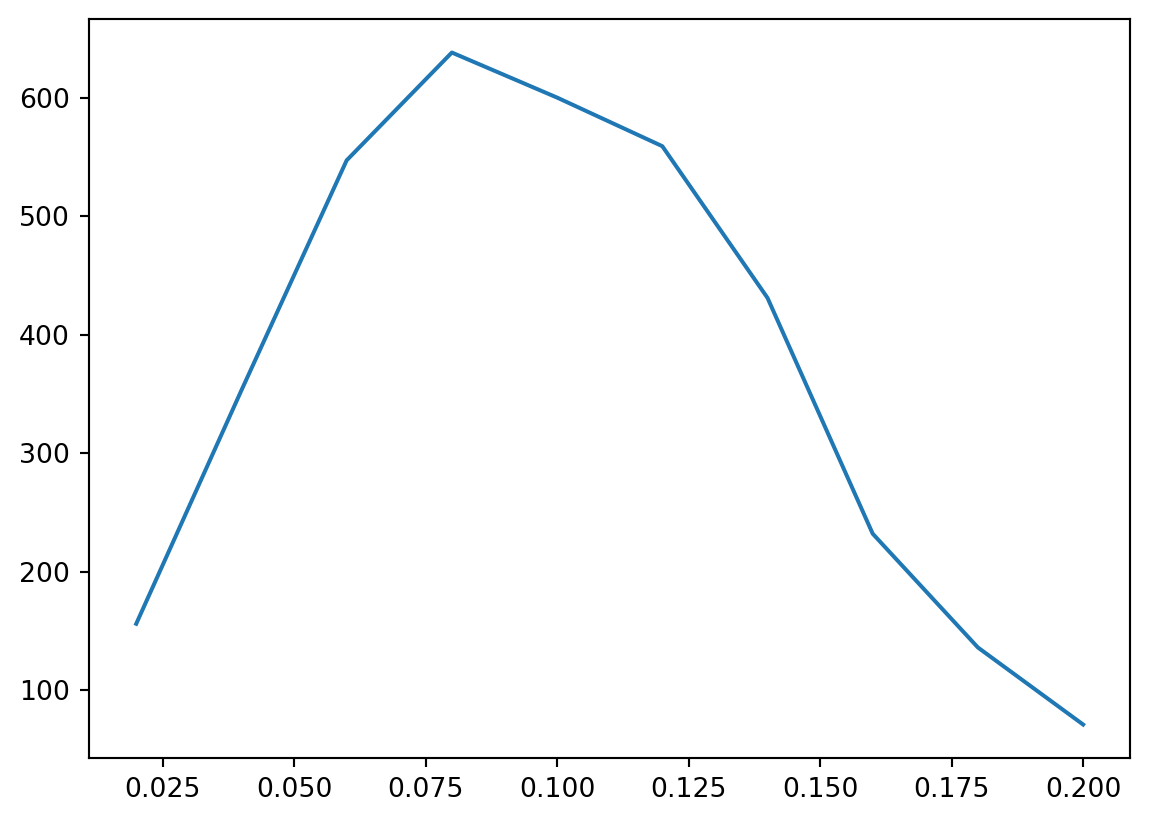

In [ ]:
plt.plot(eps_lst, clust_cnt)

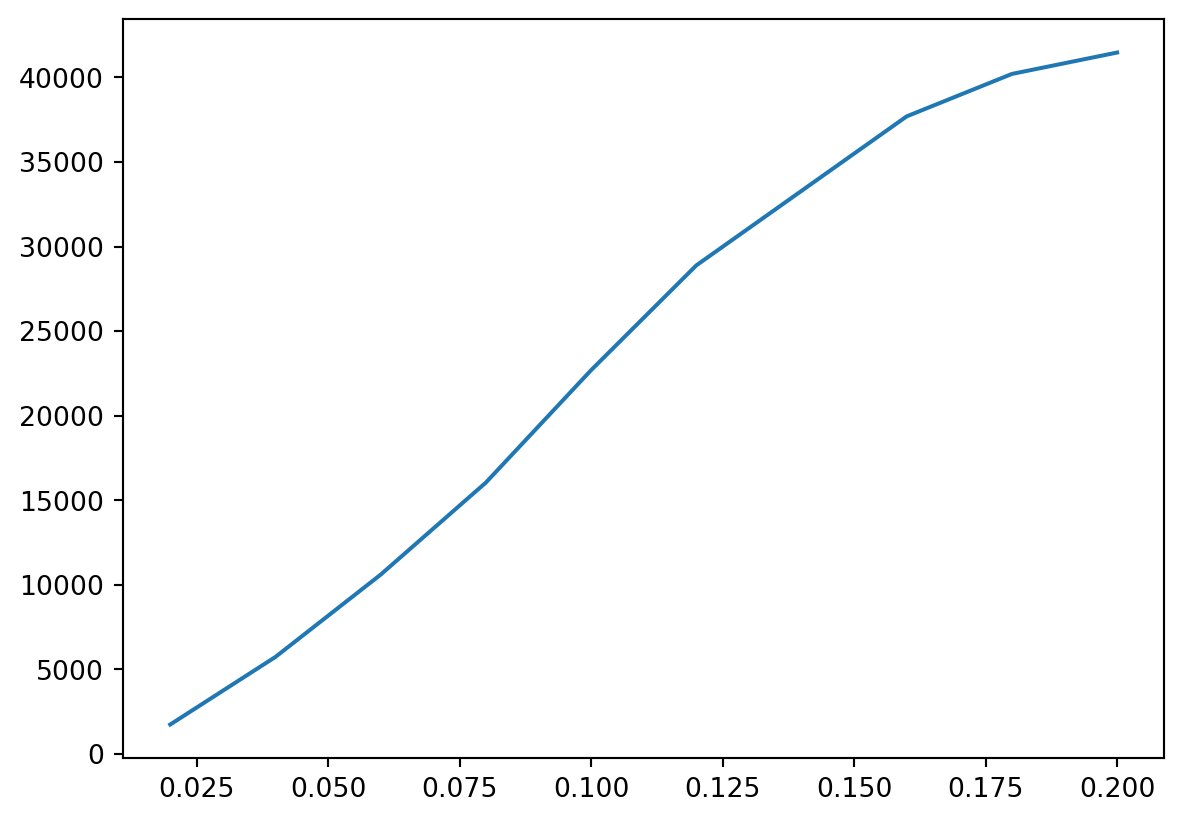

In [ ]:
plt.plot(eps_lst, elem_cnt)

Берем eps=0.075 


In [21]:
eps = 0.075
cluster_model = DBSCAN(eps=eps, min_samples=5)
topic_model = BERTopic(
    language="multilingual",
    embedding_model='cointegrated/rubert-tiny2',
    hdbscan_model=cluster_model)
topics, probs = topic_model.fit_transform(docs)
clust_res = topic_model.get_topic_info()

Мерджим метки класов


In [22]:
docs_info = topic_model.get_document_info(docs)
df.index = range(len(df))
docs_info = docs_info.join(df, how='left')
docs_info

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,text,category,corrected_tag,labels,temp
0,Видео лагает,22,22_зависает_периодически_тормозит_резкость,"[зависает, периодически, тормозит, резкость, о...","[Подача\nМало практики по bash, периодически з...",зависает - периодически - тормозит - резкость ...,False,Видео лагает,Видео,VP,[0. 0. 0. 0. 0. 0. 1.],VP
1,Торгом Бабаян! Спасибо вам большое за помощь в...,-1,-1_как_было_про_бы,"[как, было, про, бы, задание, не, урок, уроке,...","[Благодарю, за другой код решения 9 задачи. Да...",как - было - про - бы - задание - не - урок - ...,False,Торгом Бабаян! Спасибо вам большое за помощь в...,ДЗ,H,[0. 1. 0. 0. 0. 0. 0.],H
2,Спасибо),21,21_спасибо_дружище_принял_,"[спасибо, дружище, принял, , , , , , , ]","[Спасибо), Спасибо), Спасибо)]",спасибо - дружище - принял - - - - - - -,True,Спасибо),ДЗ,H,[0. 1. 0. 0. 0. 0. 0.],H
3,комментарий содержит нерелевантную информацию ...,-1,-1_как_было_про_бы,"[как, было, про, бы, задание, не, урок, уроке,...","[Благодарю, за другой код решения 9 задачи. Да...",как - было - про - бы - задание - не - урок - ...,False,комментарий содержит нерелевантную информацию ...,ДЗ,H E,[1. 1. 0. 0. 0. 0. 0.],H
4,комментарий содержит нерелевантную информацию ...,-1,-1_как_было_про_бы,"[как, было, про, бы, задание, не, урок, уроке,...","[Благодарю, за другой код решения 9 задачи. Да...",как - было - про - бы - задание - не - урок - ...,False,комментарий содержит нерелевантную информацию ...,ДЗ,H E,[1. 1. 0. 0. 0. 0. 0.],E
...,...,...,...,...,...,...,...,...,...,...,...,...
68752,Крайне раздражают некоторые детали)\nНапример ...,-1,-1_как_было_про_бы,"[как, было, про, бы, задание, не, урок, уроке,...","[Благодарю, за другой код решения 9 задачи. Да...",как - было - про - бы - задание - не - урок - ...,False,Крайне раздражают некоторые детали)\nНапример ...,NaN,LMS,[0. 0. 1. 0. 0. 0. 0.],LMS
68753,321.Профессия Бизнес-аналитик\nАналитик данных...,24,24_аналитик_финансовый_382_анализ,"[аналитик, финансовый, 382, анализ, 408, профе...",[382.Финансовый аналитик 2.0\nповерхностный ма...,аналитик - финансовый - 382 - анализ - 408 - п...,False,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN,VC VP,[0. 0. 0. 0. 0. 1. 1.],VC
68754,321.Профессия Бизнес-аналитик\nАналитик данных...,24,24_аналитик_финансовый_382_анализ,"[аналитик, финансовый, 382, анализ, 408, профе...",[382.Финансовый аналитик 2.0\nповерхностный ма...,аналитик - финансовый - 382 - анализ - 408 - п...,False,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN,VC VP,[0. 0. 0. 0. 0. 1. 1.],VP
68755,"Системный аналитик с нуля, 1-14 модули. Не нар...",18,18_python_1239_основы_1876,"[python, 1239, основы, 1876, 76, часть, пр, ba...","[76.Профессия Python-разработчик, Курс Основы ...",python - 1239 - основы - 1876 - 76 - часть - п...,False,"Системный аналитик с нуля, 1-14 модули. Не нар...",NaN,VP VC,[0. 0. 0. 0. 0. 1. 1.],VP


Помотрим на кластера

Exaple 0 


In [ ]:
docs_info[docs_info['Topic'] == 0]['Document'].values.tolist()

['я не успела в предыдущем уроке оставить комментарий. так вот, долго думала, что не заходит в уроке? сначала меня раздражала излишняя жестикуляция . почему нельзя просто спокойно держать руки на столе? видно, что преподаватель грамотный, много знает. мастер своего дела. я только никак в толк не возьму, как от круга, квадрата и креста перешли к ирисам. для меня было бы важно именно научиться рисовать ирис, а раскрашивать его в последнюю очередь. я просмотрела урок с орнаментом, так почему не показать как вписываются птицы и цветы. мне не хватило. я хотела, чтобы больше было уделено времени для научения рисования, разбора и подбора цвета красок с их названиями. безусловно, девушка умница. мне не хватает теории в практике. с уважением Марина К.',
 'Мы пришли многие учиться с нуля. В данном видео часть процессов построения линий не показана камерой. В шитье каждый миллиметр важен и особенно то, как преподаватель это делает своей рукой! Постоянно приходится отматывать назад чтобы сообразит

In [15]:
docs_info[docs_info['Topic'] == 0].category.value_counts()

category
Видео                  568
ДЗ                     187
Общение с куратором     76
Лонгрид                 47
Тест                    30
Качество материалов      1
Интерфейс платформы      1
Name: count, dtype: int64

Exaple 1


In [16]:
docs_info[docs_info['Topic'] == 1]['Document'].values.tolist()

['Данный курс был очень полезен, поскольку погружение в него позволило насолить знания с курса "Запуск курса с 0". Валерия давала обратную связь на 100! Конкретика. Все понятно. Если не приложил усилия, то получи доработку (было несколько ситуаций, когда в спешке делала, но понимала, что это мое упущение). Благодаря Валерии Иванцовой и Ксении Майсак (1 семестр) сделала таблицу с ссылками на статьи для доп. изучения. Надеюсь, что мои знания на 4 (отметка хорошо) оправдались! Осталось доработать итоговый проект. Хотелось бы с данными кураторами ещё раз встретиться уже на 2 курсе! Топ.',
 'Добрый день, любимая команда Skilbox. Во-первых, мне очень нравится учиться здесь и лекторы и мой проверяющий преподаватель помогают мне действительно становиться опытнее. Во-вторых, я обожаю конкурсы и многие другие активности, что организует платформа. Когда я увидела начала урока, я ожидала что-то очень любопытное, но финал поверг меня в такой шок, что я даже решила об этом написать. Да, я достаточно

In [17]:
docs_info[docs_info['Topic'] == 1].category.value_counts()

category
ДЗ                     480
Общение с куратором     62
Видео                   26
Лонгрид                  3
Тест                     1
Name: count, dtype: int64

Exaple 2


In [18]:
docs_info[docs_info['Topic'] == 2]['Document'].values.tolist()

['Добрый день, Надя!\n Спасибо)\n Хорошего дня и отличного настроения',
 'Спасибо!)\n Спокойной ночи!',
 'Спасибо! И Вам хорошего вечера',
 'Добрый день,это в молдавских леях,спасибо',
 'Ануш, добрый день!) большое спасибо ',
 'Виолетта, добрый день. Благодарю! Есть цель, к которой я сейчас иду.',
 'Спасибо  \n Хорошего дня  ',
 'Добрый день! Спасибо!',
 'Добрый день, Спасибо!',
 'Добрый день, хорошо спасибо за комментарий. Хорошего дня',
 'Добрый день спасибо   хорошего дня',
 'Спасибо хорошего дня',
 'Добрый вечер спасибо большое',
 'Доброе утро спасибо большое',
 'Спасибо , да двигаемся дальше ) но пока неделя моря и отдыха  ',
 'Спасибо и вам хорошей недели',
 'Добрый день ! Благодарю за оценку!)',
 'Доброжелательный молодой человек, который разъяснял все вопросы в любое время суток   \n Спасибо,Вячеслав!))',
 'Добрый день, спасибо вам больше за приятные слова))',
 'Добрый вечер. Спасибо большое)))',
 'Вячеслав, вам спасибо , и отличного дня',
 'Благодарю!\n Хорошего вам отпуска ',

In [19]:
docs_info[docs_info['Topic'] == 2].category.value_counts()

category
ДЗ         348
Видео        4
Лонгрид      1
Тест         1
Name: count, dtype: int64

# Переразметка внутри кластеров


In [23]:
cats = ['Видео', 'ДЗ', 'Общение с куратором', 'Лонгрид', 'Тест', 'Качество материалов', 'Интерфейс платформы']

series = []

for cat in cats:

    counts = docs_info[docs_info['category'] == cat].groupby(['Topic']).size()
    counts = counts.rename(cat)

    series.append(counts)

In [24]:
res = pd.concat(series, axis=1)
res

,Видео,ДЗ,Общение с куратором,Лонгрид,Тест,Качество материалов,Интерфейс платформы
Topic,,,,,,,
-1,14222.0,8199.0,2394.0,1255.0,707.0,19.0,6.0
0,63.0,609.0,NaN,6.0,1.0,NaN,NaN
1,10.0,143.0,522.0,NaN,NaN,NaN,NaN
2,4.0,518.0,3.0,NaN,3.0,NaN,NaN
3,386.0,46.0,6.0,54.0,19.0,NaN,NaN
...,...,...,...,...,...,...,...
1014,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1304,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2190,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [25]:
res['max'] = res.max(axis=1)
res['sum'] = res.drop(columns=['max']).sum(axis=1)
res['fraq'] = res['sum'] / res['max']
res['argmax'] = res[['Видео', 'ДЗ', 'Общение с куратором', 'Лонгрид', 'Тест', 'Качество материалов', 'Интерфейс платформы']].idxmax(axis=1)

In [33]:
lst = []
for thr in np.linspace(1.0, 1.2, 50):
    print(thr)
    topic_to_change = res[res['fraq'] < thr]
    lst.append((topic_to_change['sum'] - topic_to_change['max']).sum())

1.0
1.0040816326530613
1.0081632653061225
1.0122448979591836
1.0163265306122449
1.0204081632653061
1.0244897959183674
1.0285714285714285
1.0326530612244897
1.036734693877551
1.0408163265306123
1.0448979591836736
1.0489795918367346
1.0530612244897959
1.0571428571428572
1.0612244897959184
1.0653061224489795
1.0693877551020408
1.073469387755102
1.0775510204081633
1.0816326530612246
1.0857142857142856
1.089795918367347
1.0938775510204082
1.0979591836734695
1.1020408163265305
1.1061224489795918
1.110204081632653
1.1142857142857143
1.1183673469387756
1.1224489795918366
1.126530612244898
1.1306122448979592
1.1346938775510205
1.1387755102040815
1.1428571428571428
1.146938775510204
1.1510204081632653
1.1551020408163266
1.1591836734693877
1.163265306122449
1.1673469387755102
1.1714285714285715
1.1755102040816325
1.1795918367346938
1.183673469387755
1.1877551020408164
1.1918367346938776
1.1959183673469387
1.2


In [34]:
lst

[0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 12.0,
 19.0,
 20.0,
 24.0,
 30.0,
 32.0,
 37.0,
 44.0,
 54.0,
 57.0,
 87.0,
 88.0,
 91.0,
 103.0,
 123.0,
 123.0,
 149.0,
 154.0,
 157.0,
 163.0,
 167.0,
 196.0,
 199.0,
 206.0,
 217.0,
 217.0,
 223.0,
 230.0,
 248.0,
 251.0,
 279.0,
 301.0,
 304.0,
 315.0,
 339.0,
 357.0,
 379.0,
 421.0,
 421.0,
 430.0,
 440.0,
 440.0,
 444.0,
 451.0,
 451.0]

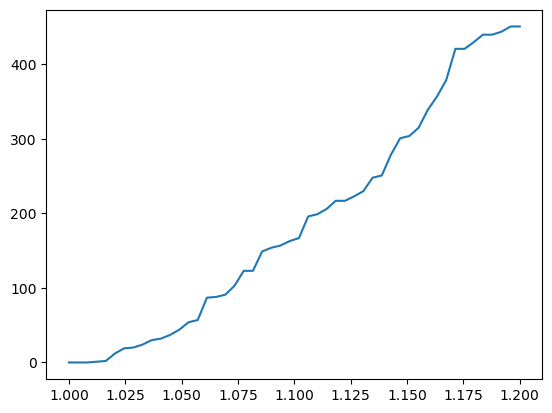

In [35]:
plt.plot(list(np.linspace(1.0, 1.2, 50)), lst)

In [28]:
thr = 1.1
topic_to_change = res[res['fraq'] < thr]

In [23]:
docs_info[docs_info['Topic'] == 15]['category'].value_counts()

category
Видео      123
ДЗ          43
Лонгрид      6
Тест         5
Name: count, dtype: int64

In [24]:
docs_info[(docs_info['Topic'] == 1) & (docs_info['category'] == 'Видео')]['Document'].values.tolist()

['Добрый день, любимая команда Skilbox. Во-первых, мне очень нравится учиться здесь и лекторы и мой проверяющий преподаватель помогают мне действительно становиться опытнее. Во-вторых, я обожаю конкурсы и многие другие активности, что организует платформа. Когда я увидела начала урока, я ожидала что-то очень любопытное, но финал поверг меня в такой шок, что я даже решила об этом написать. Да, я достаточно чувствительная, а последние жизненные события это обострили. И для меня креатив в духе - мы тебя застукали, ударили, связали и сейчас научим как дизайн делать - заставляет сжаться, выключить все и уйти. Я очень прошу, если это возможно смягчить подачу материала. Ведь сам он очень важен и нужен многим.',
 'Константин безумно харизматичный человек!!! очень зарядил меня на обучение, процесс, работу, идеи, в общем вдохновил! Подача совершенно великолепная, но не уступает и содержание, очень полезные штуки услышал, какие-то крутые инсайды и прочее. Я уже даже придумал одну прикольную механ

In [29]:
for index, row in topic_to_change.iterrows():
    docs_info.loc[docs_info.Topic == index, ['category']] = row['argmax']

In [30]:
docs_info

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,text,category,corrected_tag,labels,temp
0,Видео лагает,22,22_зависает_периодически_тормозит_резкость,"[зависает, периодически, тормозит, резкость, о...","[Подача\nМало практики по bash, периодически з...",зависает - периодически - тормозит - резкость ...,False,Видео лагает,Видео,VP,[0. 0. 0. 0. 0. 0. 1.],VP
1,Торгом Бабаян! Спасибо вам большое за помощь в...,-1,-1_как_было_про_бы,"[как, было, про, бы, задание, не, урок, уроке,...","[Благодарю, за другой код решения 9 задачи. Да...",как - было - про - бы - задание - не - урок - ...,False,Торгом Бабаян! Спасибо вам большое за помощь в...,ДЗ,H,[0. 1. 0. 0. 0. 0. 0.],H
2,Спасибо),21,21_спасибо_дружище_принял_,"[спасибо, дружище, принял, , , , , , , ]","[Спасибо), Спасибо), Спасибо)]",спасибо - дружище - принял - - - - - - -,True,Спасибо),ДЗ,H,[0. 1. 0. 0. 0. 0. 0.],H
3,комментарий содержит нерелевантную информацию ...,-1,-1_как_было_про_бы,"[как, было, про, бы, задание, не, урок, уроке,...","[Благодарю, за другой код решения 9 задачи. Да...",как - было - про - бы - задание - не - урок - ...,False,комментарий содержит нерелевантную информацию ...,ДЗ,H E,[1. 1. 0. 0. 0. 0. 0.],H
4,комментарий содержит нерелевантную информацию ...,-1,-1_как_было_про_бы,"[как, было, про, бы, задание, не, урок, уроке,...","[Благодарю, за другой код решения 9 задачи. Да...",как - было - про - бы - задание - не - урок - ...,False,комментарий содержит нерелевантную информацию ...,ДЗ,H E,[1. 1. 0. 0. 0. 0. 0.],E
...,...,...,...,...,...,...,...,...,...,...,...,...
68752,Крайне раздражают некоторые детали)\nНапример ...,-1,-1_как_было_про_бы,"[как, было, про, бы, задание, не, урок, уроке,...","[Благодарю, за другой код решения 9 задачи. Да...",как - было - про - бы - задание - не - урок - ...,False,Крайне раздражают некоторые детали)\nНапример ...,NaN,LMS,[0. 0. 1. 0. 0. 0. 0.],LMS
68753,321.Профессия Бизнес-аналитик\nАналитик данных...,24,24_аналитик_финансовый_382_анализ,"[аналитик, финансовый, 382, анализ, 408, профе...",[382.Финансовый аналитик 2.0\nповерхностный ма...,аналитик - финансовый - 382 - анализ - 408 - п...,False,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN,VC VP,[0. 0. 0. 0. 0. 1. 1.],VC
68754,321.Профессия Бизнес-аналитик\nАналитик данных...,24,24_аналитик_финансовый_382_анализ,"[аналитик, финансовый, 382, анализ, 408, профе...",[382.Финансовый аналитик 2.0\nповерхностный ма...,аналитик - финансовый - 382 - анализ - 408 - п...,False,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN,VC VP,[0. 0. 0. 0. 0. 1. 1.],VP
68755,"Системный аналитик с нуля, 1-14 модули. Не нар...",18,18_python_1239_основы_1876,"[python, 1239, основы, 1876, 76, часть, пр, ba...","[76.Профессия Python-разработчик, Курс Основы ...",python - 1239 - основы - 1876 - 76 - часть - п...,False,"Системный аналитик с нуля, 1-14 модули. Не нар...",NaN,VP VC,[0. 0. 0. 0. 0. 1. 1.],VP


In [32]:
docs_info.to_csv('new_cat.csv', index=False)